<a href="https://colab.research.google.com/github/jkwakyi/Student-Predictions/blob/main/Student_Placement_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Placement Predictor**

**Goal**: I would like to identify which factors most influenced a candidate getting placed or not.

## **Obtain**

In [20]:
# Mount Data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import set_config, metrics
set_config(display = 'diagram')
!pip install openpyxl==3.0.0

In [22]:
 # load dataset
 
df = pd.read_excel('/content/drive/MyDrive/Coding Dojo/Data/Placement_Data_Full_Class.xlsx')

df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


* sl_no = Serial Number
* gender = gender
  * Male = M
  * Felame = F
* ssc_p = Secondary Education percentage
* ssc_b = Board of Education
* hsc_p = Higher Secondary Education percentage


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


**Numerical**: 'sl_no' 'ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p', 'salary'

**Ordinal**: 'workex', 'status'

**Nominal**: 'gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'mba_p'

## **Scrub**

In [24]:
# drop salary column & set serial number as index

df.set_index(['sl_no'], drop = True, inplace = True)
df = df.drop(columns = 'salary')
df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed


* I made the serial number column the index.

* I dropped the Salary column because they the salary was dependant on if a student was placed or not. 
  * If a student wasn't placed, they would get NaN in the data

In [25]:
print('Placement Status:\n', df['status'].value_counts())
print('\n')
print('Work Experience:\n', df['workex'].value_counts())

Placement Status:
 Placed        148
Not Placed     67
Name: status, dtype: int64


Work Experience:
 No     141
Yes     74
Name: workex, dtype: int64


In [26]:
# ordinal encode workex and status

replace_workex = {'No': 0, 'Yes': 1}
df['workex'].replace(replace_workex, inplace = True)

replace_status = {'Placed': 1, 'Not Placed': 0}
df['status'].replace(replace_status, inplace = True)

df.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,0,55.0,Mkt&HR,58.80,1
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,1,86.5,Mkt&Fin,66.28,1
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,0,75.0,Mkt&Fin,57.80,1
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,0,66.0,Mkt&HR,59.43,0
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,0,96.8,Mkt&Fin,55.50,1


In [27]:
print('Placement Status:\n', df['status'].value_counts())
print('\n')
print('Work Experience:\n', df['workex'].value_counts())

Placement Status:
 1    148
0     67
Name: status, dtype: int64


Work Experience:
 0    141
1     74
Name: workex, dtype: int64


In [28]:
# check for duplicates

df[df.duplicated(keep = False)]

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,


No duplicate columns

No duplicate rows

Missing Values in the salary column

No inconsistancies

No outliers

## **Explore**

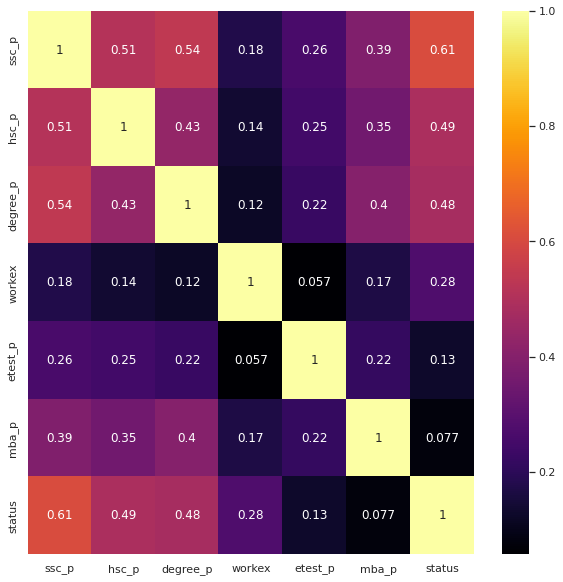

In [29]:
# create heatmap to check for correlations

corr = df.corr()

fig, ax = plt.subplots(figsize = (10, 10)) 
sns.heatmap(corr, annot = True, cmap = 'inferno')

Correlations Between features and the target 'status'

* **Strong Correlations**: Higher Secondary Education percentage('hsc_p'), Secondary Education percentage('ssc_p'), Degree Percentage('degree_p'

* **Moderate Correlations**: Work Experiece('workex'), Employability test percentage('etest_p')

[Text(0, 0, 'Not Placed'), Text(0, 0, 'Placed')]

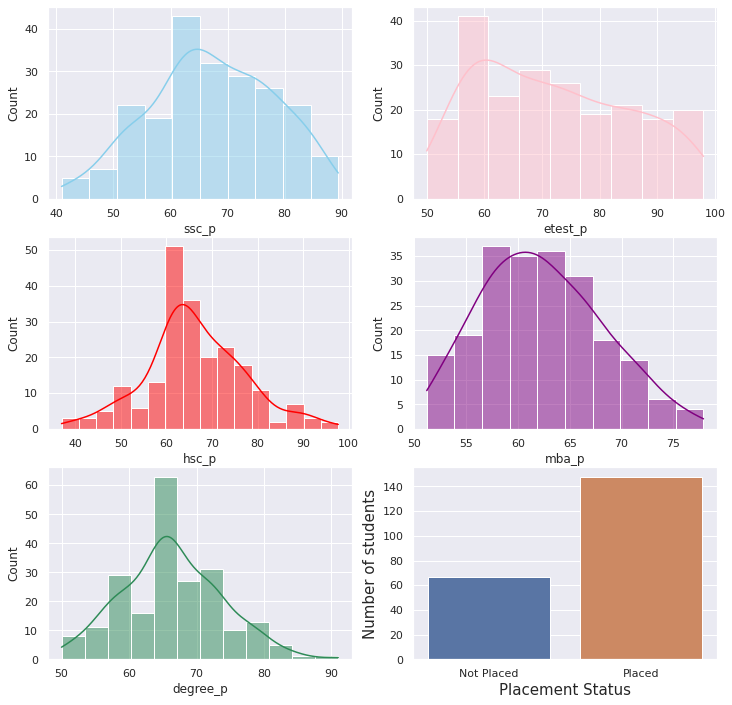

In [30]:
# create histograms for all features

sns.set(style = 'darkgrid')

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

sns.histplot(data = df, x = 'ssc_p', color ='skyblue', kde = True, ax = axs[0, 0])
sns.histplot(data = df, x = 'hsc_p', color ='red', kde = True, ax = axs[1, 0])
sns.histplot(data = df, x = 'degree_p', color ='seagreen', kde = True, ax = axs[2, 0])
sns.histplot(data = df, x = 'etest_p', color ='pink', kde = True, ax = axs[0, 1])
sns.histplot(data = df, x = 'mba_p', color ='purple', kde = True, ax = axs[1, 1])
barplot = sns.barplot(data = df, x = df['status'].value_counts(), y = df['status'].value_counts(), ax = axs[2, 1])
barplot.set_xlabel('Placement Status', fontsize = 15)
barplot.set_ylabel('Number of students', fontsize = 15)
barplot.set_xticklabels(['Not Placed', 'Placed'])

We see a dignificantly higher amount of placed students.

In [31]:
df['status'].value_counts(normalize = True)

1    0.688372
0    0.311628
Name: status, dtype: float64

We have unbalanced data

I was going to include the 'object' columns at first but after reviewing the data, I have determined that those columns are futile. Since the placement data is so unbalanced, only numerical values should be evaluated. I will not include them during the train test split portion.

[source](https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn)

## **Modeling**

### **Train Test Split**

In [32]:
df.head(2)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
sl_no,,,,,,,,,,,,,
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,0,55.0,Mkt&HR,58.80,1
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,1,86.5,Mkt&Fin,66.28,1


In [39]:
# instantiate the categorical and numeric column selectors to select appropriate columns
num_selector = make_column_selector(dtype_include = 'number')
df[num_selector(df)]



,ssc_p,hsc_p,degree_p,workex,etest_p,mba_p,status
sl_no,,,,,,,
1,67.00,91.00,58.00,0,55.0,58.80,1
2,79.33,78.33,77.48,1,86.5,66.28,1
3,65.00,68.00,64.00,0,75.0,57.80,1
4,56.00,52.00,52.00,0,66.0,59.43,0
5,85.80,73.60,73.30,0,96.8,55.50,1
...,...,...,...,...,...,...,...
211,80.60,82.00,77.60,0,91.0,74.49,1
212,58.00,60.00,72.00,0,74.0,53.62,1
213,67.00,67.00,73.00,1,59.0,69.72,1


In [40]:
df = df[num_selector(df)]

In [42]:
# train test split

y = df['status']
X = df.drop(columns = 'status')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.head()

,ssc_p,hsc_p,degree_p,workex,etest_p,mba_p
sl_no,,,,,,
121,58.0,40.0,59.0,0,73.00,58.81
30,62.0,67.0,58.0,0,77.00,51.29
20,60.0,67.0,70.0,1,50.48,77.89
70,73.0,73.0,66.0,1,70.00,68.07
98,70.5,62.5,61.0,0,93.91,69.03


In [44]:
pd.DataFrame(y_train)

,status
sl_no,
121,0
30,0
20,1
70,1
98,0
...,...
107,0
15,0
93,1


### **Logistic Regression Model**

* Logistic Regression models are good to use when trying to estimate the relationship between features and target when the target is categorical.
  * Placement status is categorical because the student is either yes:placed, or no:not placed
    * Remember, Placement status was ordinally encoded to be either 1 for placed or a 0 for not placed.

* Logistic Regression is best used for binary targets and due to the ordinal encoding, we have a binary target.

In [46]:
# instantiate Logistic Regression model
logreg = LogisticRegression()

# instantiate the scaler
scaler = StandardScaler()

# instantiate pipeline
logreg_pipe = make_pipeline(scaler, logreg)

# fit model
logreg_pipe.fit(X_train, y_train)

# print results
print('Logistic Regression R^2 Scores')
print('\n')
print('Training Data:')
print(logreg_pipe.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(logreg_pipe.score(X_test, y_test))

Logistic Regression R^2 Scores


Training Data:
0.8757763975155279


Testing Data:
0.7962962962962963


* The results are fair but they can definitly improve.
  * I believe the issue is due to the multicollinearity of the data. 

* There is more overfitting than I am comfortable with

#### **Tuning**

* I chose L2 logistic regression because Logistic regression models work well with classification and utilizing the L2 method will reduce noise from high amount of multicollinearity features in the data.

* L2 will also help with reducing over-fitting.

{0.0001: 0.7407407407407407,
 0.001: 0.7407407407407407,
 0.01: 0.8148148148148148,
 0.1: 0.7777777777777778,
 1: 0.7962962962962963,
 10: 0.8333333333333334,
 100: 0.8333333333333334,
 1000: 0.8333333333333334}

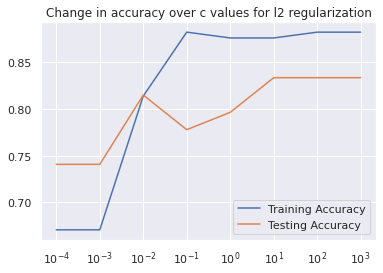

In [56]:
# create list of c values and empty list for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []

# iterative over the c values
for c in c_values:
  log_reg = LogisticRegression(C = c, max_iter = 1000, solver = 'newton-cg',
                               penalty = 'l2')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train, y_train)
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))

# plot accuracy changes
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label = 'Training Accuracy');
ax.plot(c_values, test_scores, label = 'Testing Accuracy');
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over c values for l2 regularization')
ax.legend()
ax.set_xscale('log')

# print dictionary of values of c and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

With L2 regularization we get our best score at C=100, and test scores drop off much more dramatically as C increases.

With an accuracy of 83.3%, our best hyperparameter settings for our logistic regression model would be solver='newton-cg', penalty=’l2’, and C=100.

I will use l1 tuning just to verify it does not give me higher accuracy scores

In [58]:
# instantiate Logistic Regression model
l2 = LogisticRegression( C = 100, max_iter = 1000, solver = 'newton-cg',
                               penalty = 'l2')

# fit model
l2.fit(X_train, y_train)

# print results
print('Logistic Regression R^2 Scores')
print('\n')
print('Training Data:')
print(l2.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(l2.score(X_test, y_test))

Logistic Regression R^2 Scores


Training Data:
0.8819875776397516


Testing Data:
0.8333333333333334


{0.0001: 0.25925925925925924,
 0.001: 0.25925925925925924,
 0.01: 0.25925925925925924,
 0.1: 0.7777777777777778,
 1: 0.7962962962962963,
 10: 0.8333333333333334,
 100: 0.8333333333333334,
 1000: 0.8333333333333334}

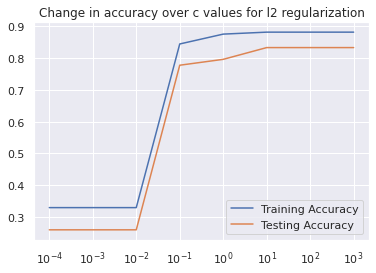

In [60]:
# create list of c values and empty list for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []

# iterative over the c values
for c in c_values:
  log_reg = LogisticRegression(C = c, max_iter = 1000, solver = 'liblinear',
                               penalty = 'l1')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train, y_train)
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))

# plot accuracy changes
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label = 'Training Accuracy');
ax.plot(c_values, test_scores, label = 'Testing Accuracy');
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over c values for l2 regularization')
ax.legend()
ax.set_xscale('log')

# print dictionary of values of c and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

In [61]:
# instantiate Logistic Regression model
l1 = LogisticRegression(C = 100, max_iter = 1000, solver = 'liblinear',
                               penalty = 'l1')

# fit model
l1.fit(X_train, y_train)

# print results
print('Logistic Regression R^2 Scores')
print('\n')
print('Training Data:')
print(l1.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(l1.score(X_test, y_test))

Logistic Regression R^2 Scores


Training Data:
0.8757763975155279


Testing Data:
0.8518518518518519


* Reducing the weight of the features with l1 regularization seems to be the better of the two models. 
  * There is much less over-fitting and a higher accuracy score.

### **Decision Tree**

* I will be utilizing a decision tree model in order to see if class based classification produces better accuracy scores.

In [74]:
# instantiate decision tree model
dec_tree = DecisionTreeClassifier(random_state = 42)

# fit decision tree
dec_tree.fit(X_train, y_train)

# print results
print('Decision Tree R^2 Scores')
print('\n')
print('Training Data:')
print(dec_tree.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(dec_tree.score(X_test, y_test))

Decision Tree R^2 Scores


Training Data:
1.0


Testing Data:
0.8148148148148148


* The decision tree was able to perfectly predict the outcomes in the training data but there was a gross overfitting as well as a massive accuracy drop.

* I will see what the best max leaf nodes would be

Text(0, 0.5, 'R2')

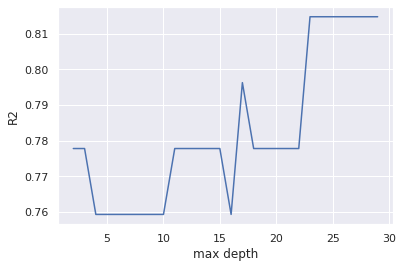

In [78]:
# find optimal depth
forest = list(range(2, 30))

r2 = []

# create a function to cycle through the depths
for leaves in forest:
  dec_tree = DecisionTreeClassifier(max_leaf_nodes = leaves, random_state = 42,
                                    class_weight = 'balanced')
  dec_tree.fit(X_train, y_train)
  score = dec_tree.score(X_test, y_test)
  r2.append(score)

#visualize optimal depth with the highest r2
plt.plot(forest, r2)
plt.xlabel('max depth')
plt.ylabel('R2')

In [77]:
# instantiate decision tree model
dec_tree = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced', 
                                  max_leaf_nodes = 25)

# fit decision tree
dec_tree.fit(X_train, y_train)

# print results
print('Decision Tree R^2 Scores')
print('\n')
print('Training Data:')
print(dec_tree.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(dec_tree.score(X_test, y_test))

Decision Tree R^2 Scores


Training Data:
1.0


Testing Data:
0.8148148148148148


* As shown in the graph, the highest accuracy I will get from this model is 81%. 
* I tried adding other hyperparameters but the testing accuracy wouldn't go any higher.
  * This is probably because leave purity is inevitable.

* I more than likely will not suggest this model

#### **Boost**

In [116]:

# define function that will display booster scores, confusion matix, roc graph, and classification report

def evaluate_classification(model, X_test, y_test, cmap = None, 
                            classes = None, figsize = (20, 5)):
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, target_names = classes,
                                      zero_division = 0))

  fig, ax = plt.subplots(ncols = 3, figsize = figsize)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'Reds',
                                        display_labels = classes,
                                        ax = ax[0])
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'Purples',
                                        display_labels = classes, normalize = 'true',
                                        ax = ax[1])
  curve = metrics.plot_roc_curve(model, X_test, y_test, ax = ax[2])
  curve.ax_.grid()
  curve.ax_.plot([0,1], [0, 1], ls = ':')

              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.84      0.95      0.89        40

    accuracy                           0.83        54
   macro avg       0.81      0.72      0.75        54
weighted avg       0.83      0.83      0.82        54

Gradient Boost R^2 Scores


Training Data:
1.0


Testing Data:
0.8333333333333334


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


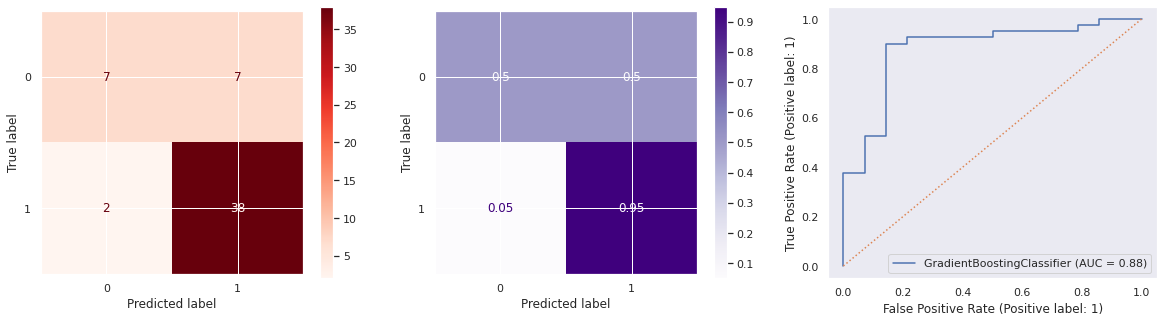

In [122]:
# Instantiate and fit xgb and evaluate

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

evaluate_classification(gbc, X_test, y_test)

# print results
print('Gradient Boost R^2 Scores')
print('\n')
print('Training Data:')
print(gbc.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(gbc.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.84      0.95      0.89        40

    accuracy                           0.83        54
   macro avg       0.81      0.72      0.75        54
weighted avg       0.83      0.83      0.82        54

LightGBM Tree R^2 Scores


Training Data:
1.0


Testing Data:
0.8333333333333334


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


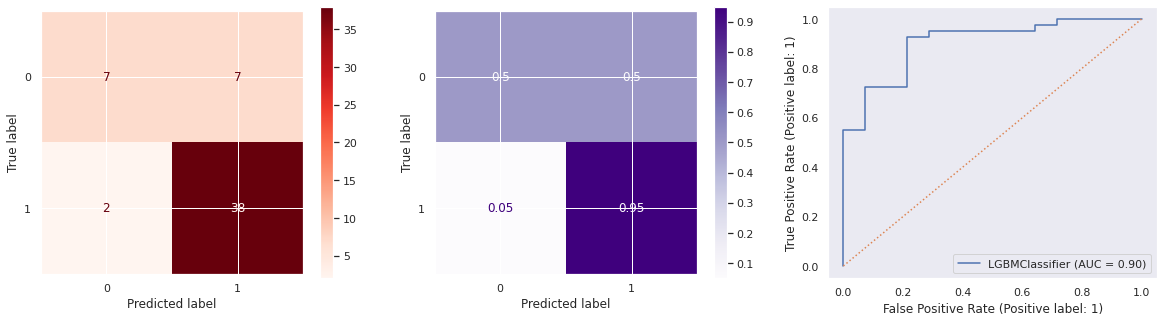

In [123]:
# Instantiate and fit lgbm and evaluate

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)

evaluate_classification(lgbm, X_test, y_test)

# print results
print('LightGBM Tree R^2 Scores')
print('\n')
print('Training Data:')
print(lgbm.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(lgbm.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.75      0.43      0.55        14
           1       0.83      0.95      0.88        40

    accuracy                           0.81        54
   macro avg       0.79      0.69      0.71        54
weighted avg       0.81      0.81      0.80        54

XGBoost R^2 Scores


Training Data:
0.9937888198757764


Testing Data:
0.8148148148148148


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


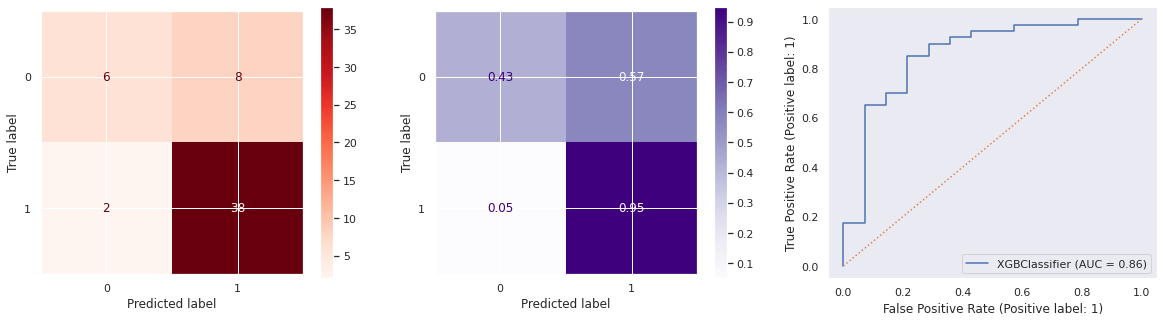

In [124]:
# Instantiate and fit xgb and evaluate

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

evaluate_classification(xgb, X_test, y_test)

# print results
print('XGBoost R^2 Scores')
print('\n')
print('Training Data:')
print(xgb.score(X_train, y_train))
print('\n')
print('Testing Data:')
print(xgb.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.88      0.93      0.90        40

    accuracy                           0.85        54
   macro avg       0.82      0.78      0.80        54
weighted avg       0.85      0.85      0.85        54



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


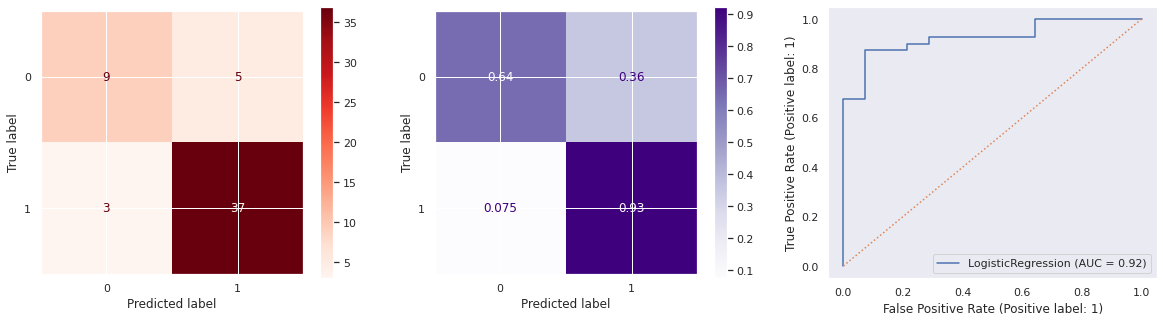

In [120]:
evaluate_classification(l1, X_test, y_test)

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        14
           1       0.86      0.93      0.89        40

    accuracy                           0.83        54
   macro avg       0.79      0.75      0.77        54
weighted avg       0.83      0.83      0.83        54



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


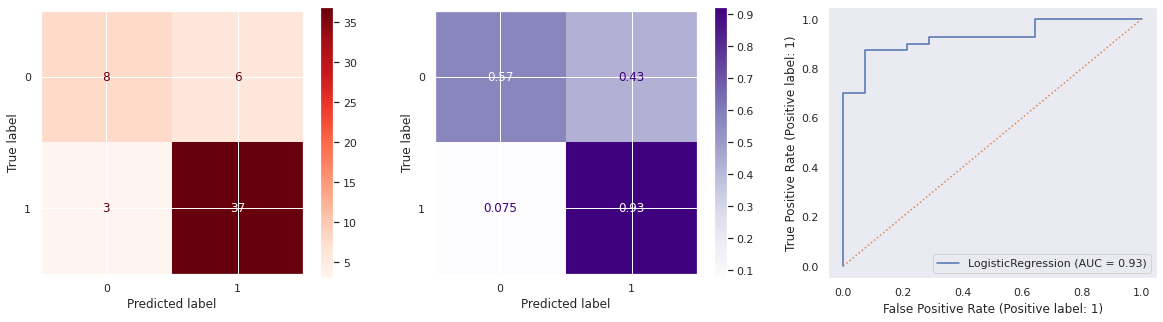

In [121]:
evaluate_classification(l2, X_test, y_test)

* The best product to use for student prediction would be a logisit regression model with a l1 penalty

* The l1 logistic regression model has good results:
  * Highest testing accuracy score amongst all other models
  * The lest overfit model
  * Fewest false positives which is good because the model can limit the amount of unqualified students the best out of all the models
  * The Area under the curve is .93 which means the model fairs well when it comes to clearly defining classes on its own.